In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from commando import ComManDo
from commando.evaluation import generate_figure, test_partial
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-04-05 21:06:07.558801: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-05 21:06:07.558837: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
data1 = pd.read_csv("../data/scMNC/mouse_visual_cortex/data/geneExp_filtered.csv")
data2 = pd.read_csv("../data/scMNC/mouse_visual_cortex/data/efeature_filtered.csv")
sample_names1 = data1.columns[1:]
sample_names2 = np.array(data2)[:, 0]
assert (sample_names1 == sample_names2).all()
data1 = np.transpose(np.array(data1)[:, 1:])
data2 = np.array(data2)[:, 3:]
meta = pd.read_csv("../data/scMNC/mouse_visual_cortex/data/20200711_patchseq_metadata_mouse.csv")[['transcriptomics_sample_id', 'hemisphere']]
meta = np.array(meta)
meta_idx = [np.argwhere(meta[:, 0] == sample_names1[i])[0][0] for i in range(sample_names1.shape[0])]
type1 = type2 = meta[meta_idx, 1]

# Sampling
idx = np.random.choice(range(data1.shape[0]), 500, replace=False)
data1, data2, type1, type2 = (x[idx] for x in (data1, data2, type1, type2))
idx = np.random.choice(range(data1.shape[1]), 20, replace=False)
data1 = data1[:, idx]
idx = np.random.choice(range(data2.shape[1]), 20, replace=False)
data2 = data2[:, idx]

# Labels
labels = [type1,type2]

# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
dataset = [data1, data2]

# Utility
positivize = lambda X: [(1 + preprocessing.scale(1 + x)) / 2 for x in X]

In [4]:
# Reduced Priors
full_priors = np.eye(len(dataset[0]))

random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)

none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

In [5]:
# Vars
reduced_dim = 2

# ComManDo

In [6]:
cm = ComManDo(output_dim=reduced_dim, epoch_DNN=2000, log_DNN=500)
cm_data = cm.fit_transform(dataset=dataset)

use random seed: 666
Shape of Raw data
Dataset 0: (500, 20)
Dataset 1: (500, 20)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.0696 alpha:0.3067
epoch:[1000/2000] err:0.0815 alpha:0.3602
epoch:[1500/2000] err:0.0887 alpha:0.3944
epoch:[2000/2000] err:0.0929 alpha:0.4161
Finished Matching!
---------------------------------
Performing NLMA
epoch:[500/2000]: loss:1.210382
epoch:[1000/2000]: loss:1.010117
epoch:[1500/2000]: loss:1.003542
epoch:[2000/2000]: loss:1.002004
Finished Mapping!
---------------------------------
ComManDo Done!
Distance: 0.19578094499956933
Correspondence: 8.444135713998548
Mapping: 37.366837315999874
Total: 46.00675397499799


In [7]:
cm_data_half = ComManDo(output_dim=reduced_dim, epoch_DNN=2000, log_DNN=500, P=half_priors).fit_transform(dataset=dataset)
cm_data_none = ComManDo(output_dim=reduced_dim, epoch_DNN=2000, log_DNN=500, P=none_priors).fit_transform(dataset=dataset)

use random seed: 666
Shape of Raw data
Dataset 0: (500, 20)
Dataset 1: (500, 20)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.0696 alpha:0.3067
epoch:[1000/2000] err:0.0815 alpha:0.3602
epoch:[1500/2000] err:0.0887 alpha:0.3944
epoch:[2000/2000] err:0.0929 alpha:0.4161
Finished Matching!
---------------------------------
Performing NLMA
epoch:[500/2000]: loss:1.223118
epoch:[1000/2000]: loss:1.014231
epoch:[1500/2000]: loss:1.003144
epoch:[2000/2000]: loss:1.000020
Finished Mapping!
---------------------------------
ComManDo Done!
Distance: 0.22445326000161003
Correspondence: 8.3404197619966
Mapping: 38.66473970799416
Total: 47.22961272999237
use random seed: 666
Shape of Raw data
Dataset 0: (500, 20)
Dataset 1: (500, 20)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.0696 alpha:0.3067
epoch:[1000/2000] err:0.0815 alpha:0.3602
epoch:[1500

# UnionCom

In [8]:
uc = ComManDo(project_mode='tsne', output_dim=reduced_dim)
uc_data = uc.fit_transform(dataset=positivize(dataset))

use random seed: 666
Shape of Raw data
Dataset 0: (500, 20)
Dataset 1: (500, 20)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.0696 alpha:0.3067
epoch:[1000/2000] err:0.0815 alpha:0.3602
epoch:[1500/2000] err:0.0887 alpha:0.3944
epoch:[2000/2000] err:0.0929 alpha:0.4161
Finished Matching!
---------------------------------
Begin finding the embedded space
epoch:[10/100]: loss:5.036484, align_loss:0.178384
epoch:[20/100]: loss:4.828626, align_loss:0.186358
epoch:[30/100]: loss:4.926615, align_loss:0.179942
epoch:[40/100]: loss:4.790275, align_loss:0.168383
epoch:[50/100]: loss:4.852884, align_loss:0.176913
epoch:[60/100]: loss:4.705166, align_loss:0.175881
epoch:[70/100]: loss:4.584388, align_loss:0.175458
epoch:[80/100]: loss:4.430761, align_loss:0.155595
epoch:[90/100]: loss:4.471778, align_loss:0.125646
epoch:[100/100]: loss:4.457449, align_loss:0.209258
Done
---------------------------------
ComManDo Done!
Dis

# Nonlinear Manifold Alignment

In [9]:
nlma_data, _ = mmd_combine(data1, data2, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim)

In [10]:
nlma_data_half, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim, corr=half_priors)

# Figure Generation

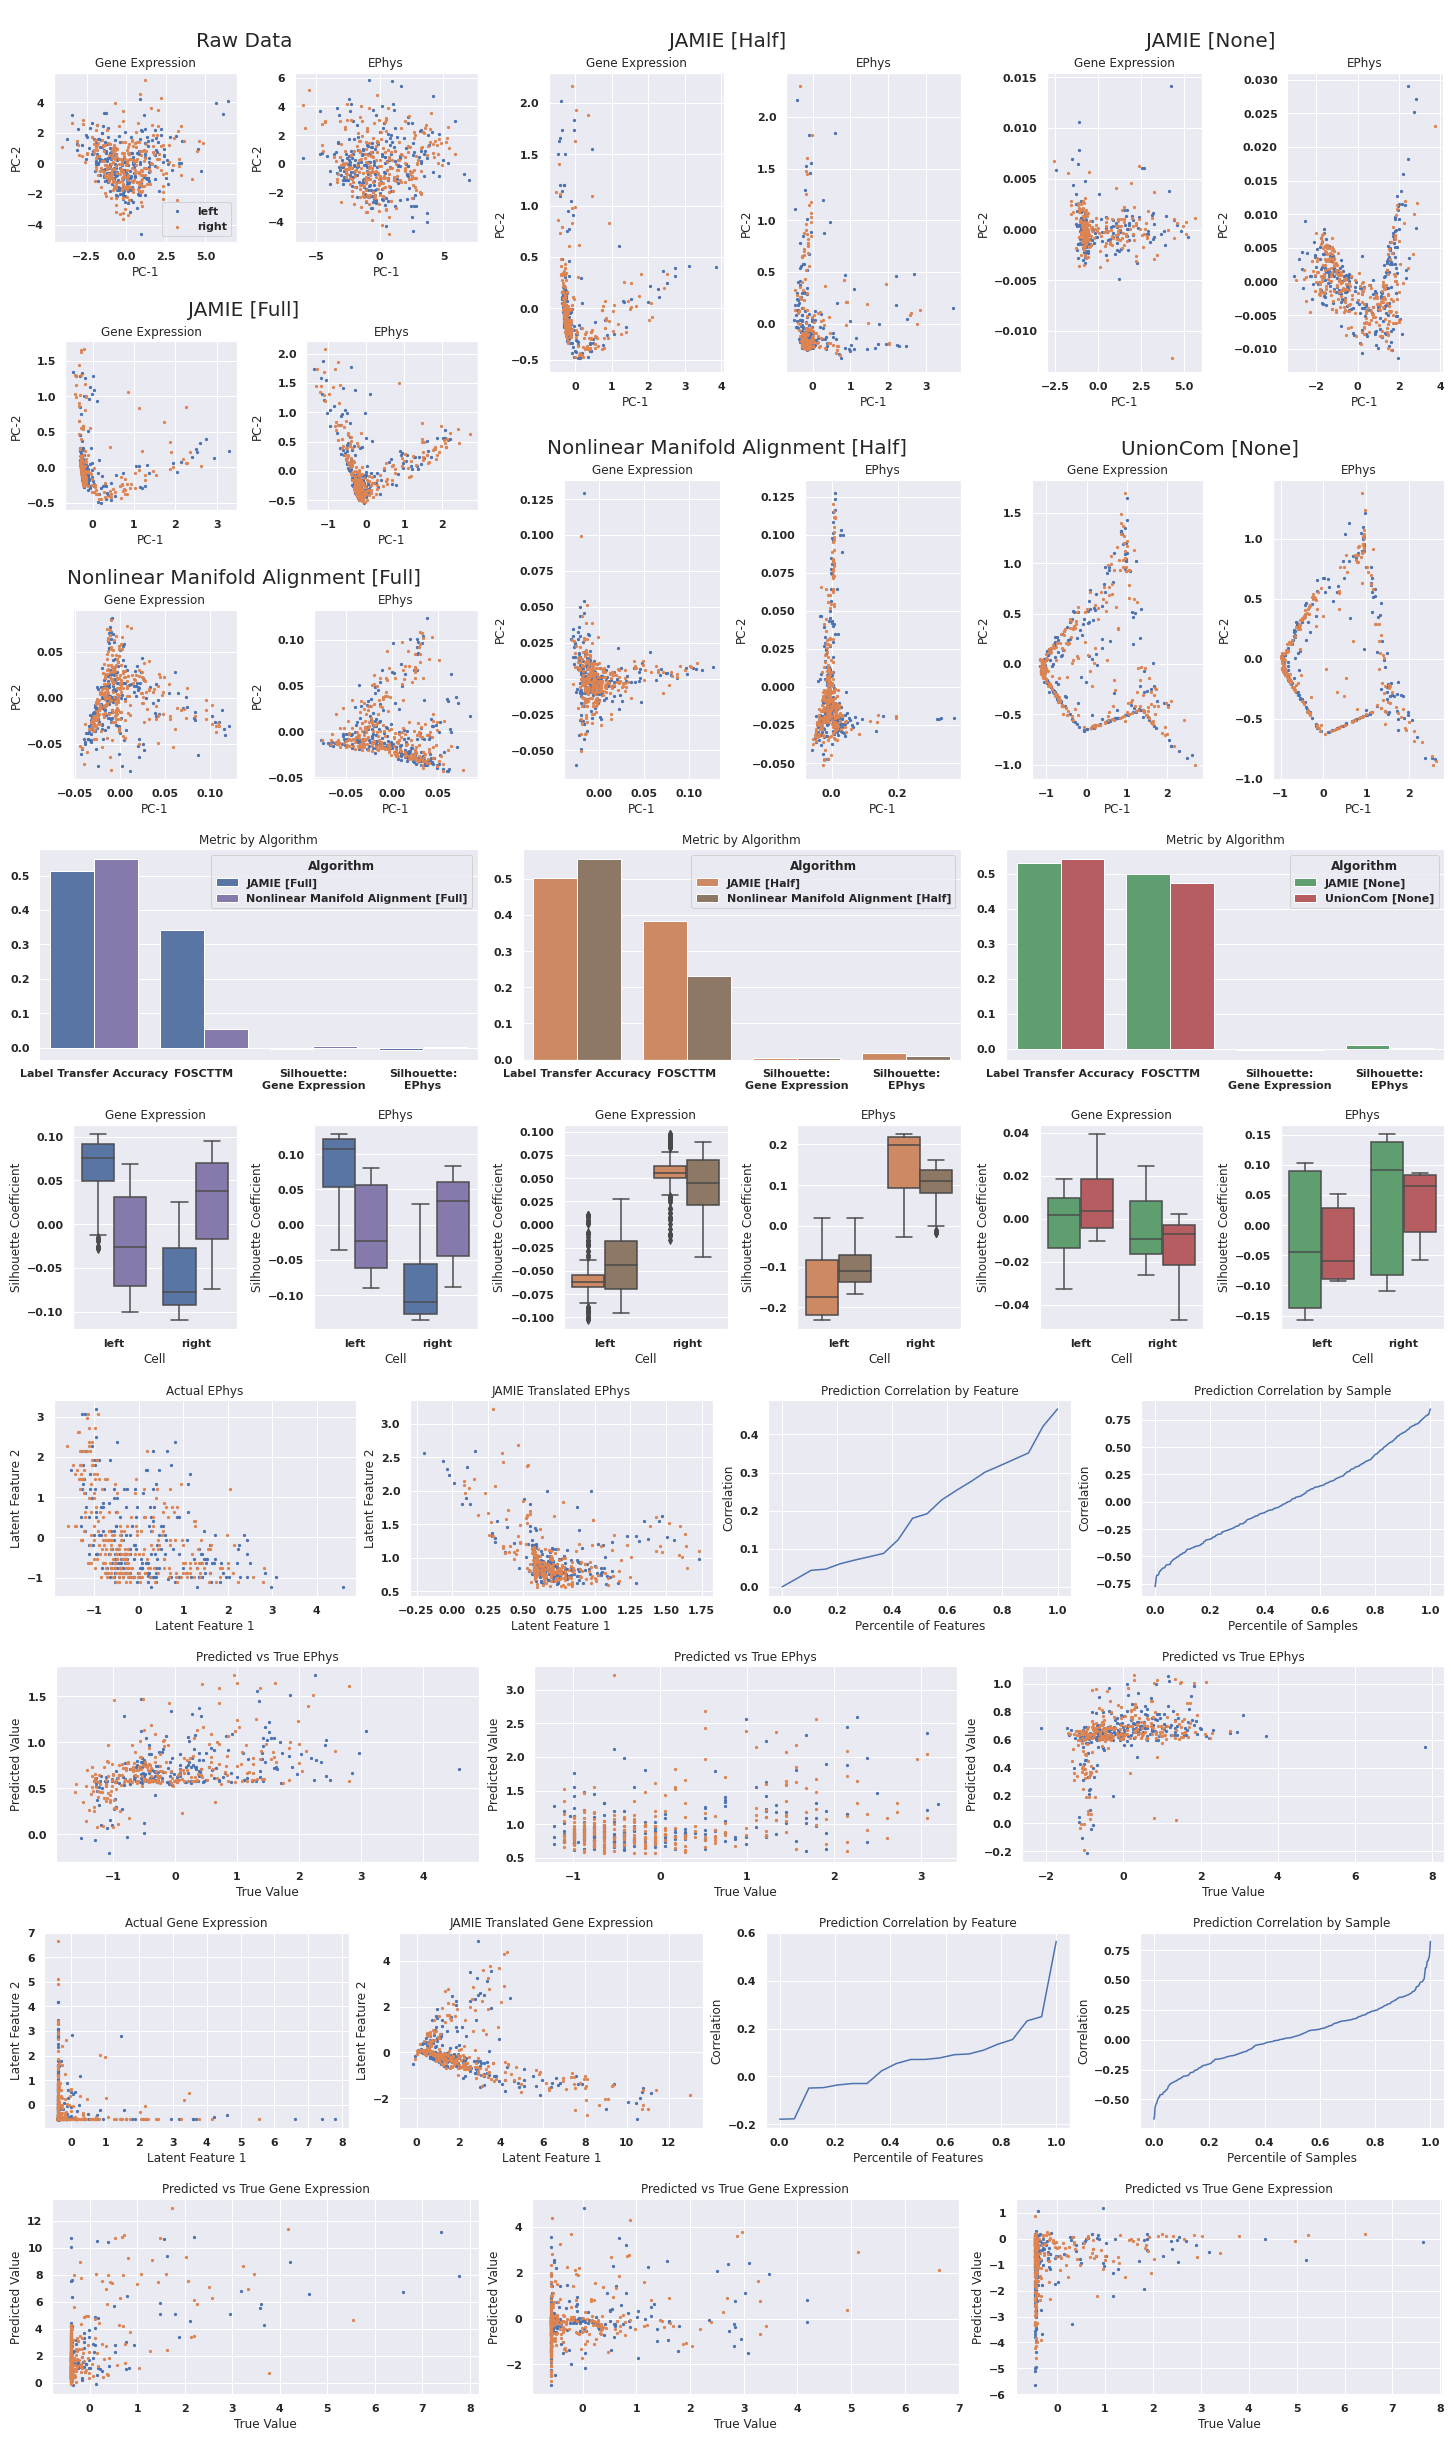

In [11]:
#%%capture --no-display
params = {
    'dataset_names': ['Gene Expression', 'EPhys'],
    'integrated_data': [cm_data, cm_data_half, cm_data_none, uc_data, nlma_data, nlma_data_half],
    'integrated_alg_names': ['JAMIE [Full]', 'JAMIE [Half]', 'JAMIE [None]', 'UnionCom [None]', 'Nonlinear Manifold Alignment [Full]', 'Nonlinear Manifold Alignment [Half]'],
    'alg_groups': [0, 1, 2, 2, 0, 1],
    'raw_data_group': 0,
    'integrated_rows': 1,
    'scale': 20,
    'integrated_use_pca': True,
    'skip_partial': True,
    'skip_nn': True,
    'skip_simple': True,
}
generate_figure(cm, dataset, labels, **params)